In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix, precision_score, recall_score, f1_score
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import weight_norm

In [2]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        y1 = self.tcn(x.transpose(1, 2))  # transpose to have channel as the second dimension
        o = self.linear(y1[:, :, -1])  # The output from the last timestep
        return o.squeeze()


In [3]:
# Data load
data = pd.read_csv('final_data.csv')

median_age = data.loc[data['age_years'] <= 100, 'age_years'].median()
data.loc[data['age_years'] > 100, 'age_years'] = median_age
gender_one_hot = pd.get_dummies(data['gender'], prefix='gender')
data = pd.concat([data, gender_one_hot], axis=1)
data.drop('gender', axis=1, inplace=True)
data['time_window_numeric'] = data['time_window'].str.extract(r'\, (\d+\.?\d*)\]').astype(float)
data = data.drop('time_window', axis=1)

features = data.drop(['mortality_24h'], axis=1)
labels = data['mortality_24h'].values.reshape(-1, 1)

scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)
features_tensor = torch.tensor(features_normalized, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [5]:
# TCN
input_channels = X_train_tensor.shape[1]  # same as input_size
output_channels = 1  # binary classification
num_channels = [25, 50, 100]  # example architecture of the network
kernel_size = 7  # size of the kernel
dropout = 0.2  # dropout rate

model = TCN(input_channels, output_channels, num_channels, kernel_size, dropout)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
pos_weight = torch.tensor([38633/421], device=device)  
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

C:\Users\ALIENWARE\miniconda3\envs\pytorch\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
C:\Users\ALIENWARE\miniconda3\envs\pytorch\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
# Cross Validation
# Similar cross_validate function as used with LSTM but adapted for TCN
def cross_validate(model, criterion, optimizer, X, y, epochs=20, k=5, patience=3):
    device = next(model.parameters()).device
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X.numpy())):
        best_val_loss = float('inf')
        patience_counter = 0
        X_train_fold = torch.tensor(X[train_idx].numpy(), device=device, dtype=torch.float32)
        y_train_fold = torch.tensor(y[train_idx].numpy(), device=device, dtype=torch.float32)
        X_val_fold = torch.tensor(X[val_idx].numpy(), device=device, dtype=torch.float32)
        y_val_fold = torch.tensor(y[val_idx].numpy(), device=device, dtype=torch.float32)
        model.to(device)
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_fold.unsqueeze(1))
            loss = criterion(output, y_train_fold.squeeze())
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_output = model(X_val_fold.unsqueeze(1))
                val_loss = criterion(val_output, y_val_fold.squeeze())

            print(f"Fold {fold}, Epoch {epoch}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss.item()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping triggered at fold {fold}, epoch {epoch}.")
                break

# Training and evaluation code remains similar to LSTM example provided previously.
cross_validate(model, criterion, optimizer, features_tensor, labels_tensor, epochs=20, k=5, patience=3)


Fold 0, Epoch 0, Training Loss: 1.383946180343628, Validation Loss: 1.3333103656768799
Fold 0, Epoch 1, Training Loss: 1.382786750793457, Validation Loss: 1.331497311592102
Fold 0, Epoch 2, Training Loss: 1.3820017576217651, Validation Loss: 1.32998788356781
Fold 0, Epoch 3, Training Loss: 1.3813962936401367, Validation Loss: 1.3287713527679443
Fold 0, Epoch 4, Training Loss: 1.380985140800476, Validation Loss: 1.3278226852416992
Fold 0, Epoch 5, Training Loss: 1.3804872035980225, Validation Loss: 1.3270461559295654
Fold 0, Epoch 6, Training Loss: 1.3805782794952393, Validation Loss: 1.3263400793075562
Fold 0, Epoch 7, Training Loss: 1.3805005550384521, Validation Loss: 1.3256932497024536
Fold 0, Epoch 8, Training Loss: 1.3794100284576416, Validation Loss: 1.3250068426132202
Fold 0, Epoch 9, Training Loss: 1.3786647319793701, Validation Loss: 1.3242173194885254
Fold 0, Epoch 10, Training Loss: 1.3775036334991455, Validation Loss: 1.3232964277267456
Fold 0, Epoch 11, Training Loss: 1.37

Accuracy: 0.8944
AUC: 0.8453


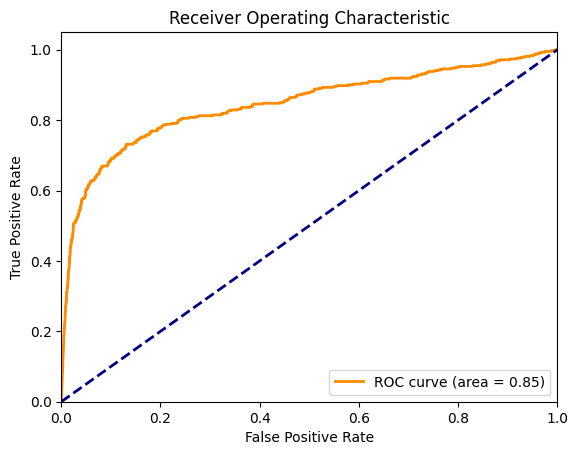

In [7]:
def evaluate_model(model, features_tensor, labels_tensor):
    model.eval()  
    with torch.no_grad(): 
        logits = model(features_tensor.unsqueeze(1).to(device))  
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()  
    true_labels = labels_tensor.cpu().numpy()  
    pred_labels = (probs > 0.5).astype(int)  
    
    accuracy = accuracy_score(true_labels, pred_labels)
    auc_score = roc_auc_score(true_labels, probs)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {auc_score:.4f}')

    # ROC
    fpr, tpr, thresholds = roc_curve(true_labels, probs)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


model.to(device) 
evaluate_model(model, features_tensor, labels_tensor)

Accuracy: 0.8944
AUROC: 0.8453
AUPRC: 0.1595


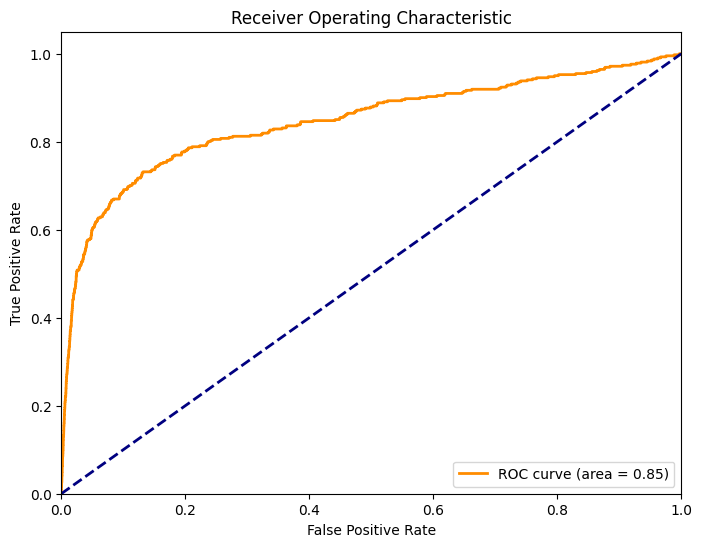

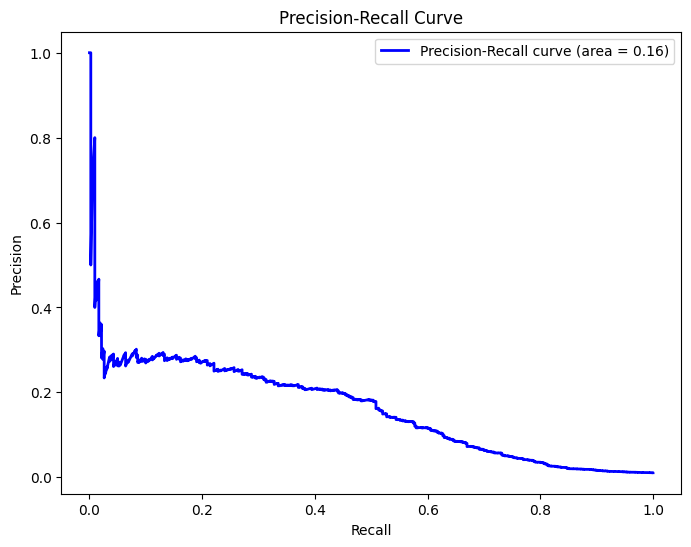

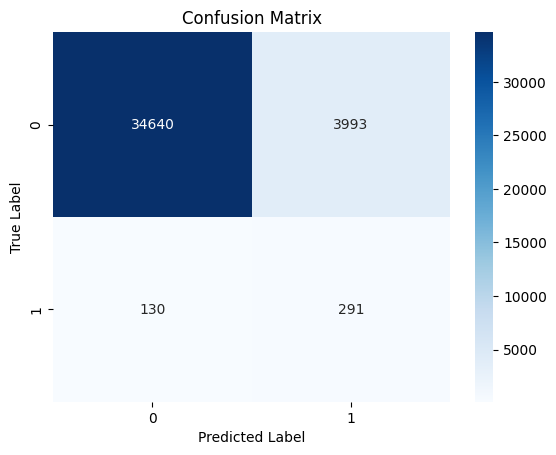

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix
import seaborn as sns
import numpy as np
import torch

def evaluate_model(model, features_tensor, labels_tensor, device):
    model.eval()  
    with torch.no_grad():  
        logits = model(features_tensor.unsqueeze(1).to(device))  
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()  
    true_labels = labels_tensor.cpu().numpy() 
    pred_labels = (probs > 0.5).astype(int)  
    
    # 
    accuracy = accuracy_score(true_labels, pred_labels)
    auc_score = roc_auc_score(true_labels, probs)
    precision, recall, _ = precision_recall_curve(true_labels, probs)
    pr_auc = auc(recall, precision)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUROC: {auc_score:.4f}')
    print(f'AUPRC: {pr_auc:.4f}')
    
    # ROC
    fpr, tpr, _ = roc_curve(true_labels, probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # PRC
    precision, recall, _ = precision_recall_curve(true_labels, probs)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  
evaluate_model(model, features_tensor, labels_tensor, device)

In [9]:
def evaluate_model(model, features_tensor, labels_tensor, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Do not compute gradient
        logits = model(features_tensor.unsqueeze(1).to(device))  # Ensure input dimension and device are correct
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()  # Apply sigmoid and convert to numpy array
    true_labels = labels_tensor.cpu().numpy()  # Convert true labels to numpy array
    pred_labels = (probs > 0.5).astype(int)  # Generate predicted labels based on probability

    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    auc_score = roc_auc_score(true_labels, probs)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUROC: {auc_score:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
evaluate_model(model, features_tensor, labels_tensor, device)

Accuracy: 0.8944
AUROC: 0.8453
Precision: 0.0679
Recall: 0.6912
F1 Score: 0.1237
